<a href="https://colab.research.google.com/github/lucabem/CompeticionMineria/blob/main/Presentacion_modelos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Descarga de datos

In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import pathlib

In [2]:
!rm -rf /root/.keras/datasets/*

Descargamos los datos de entrenamiento y test desde GitHub. Es siguiente comando guarda dicho dataset descrompirmido en el directorio /root/.keras/datasets

In [3]:
dataset_url = 'https://github.com/lucabem/CompeticionMineria/blob/main/data/dataset_images.zip?raw=true'
data_dir = tf.keras.utils.get_file(origin=dataset_url, 
                                   fname='train_data', 
                                   extract=True)

78069760/78067648 [==============================] - 1s 0us/step


In [4]:
!rm -rf /root/.keras/datasets/train_data.tar.gz /root/.keras/datasets/train_data
!ls -l /root/.keras/datasets/

total 24
drwxr-xr-x 27 root root  4096 Mar 24 09:20 ImagesTrain
drwxr-xr-x  2 root root 20480 Mar 24 09:20 Test


Comprobamos que se han descargado correctamente, mirando si tenemos 2500 imagenes (100 imagenes x clase)

In [5]:
train_path = pathlib.Path('/root/.keras/datasets/ImagesTrain')
image_count = len(list(train_path.glob('*/*.jpg')))
print(image_count)

2500


In [6]:
test_path = pathlib.Path('/root/.keras/datasets/Test')
images_test = os.listdir(test_path)
print(len(images_test))

500


Instalamos la librería *tensorflow-addons* que contiene la métrica F1Score, métrica que usaremos para evaluar los modelos.

In [7]:
!pip install tensorflow-addons

     |████████████████████████████████| 706kB 5.3MB/s 


Cargamos alguna de las librerías que usaremos posteriormente

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_addons as tfa
from keras.preprocessing.image import ImageDataGenerator  
from keras.applications import densenet  
from keras.models import Sequential, Model, load_model  
from keras.layers import Conv2D, MaxPooling2D  
from keras.layers import Activation, Dropout, Flatten, Dense  
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback  
from keras import regularizers  
from keras import backend as K  
from matplotlib import pyplot as plt
import tensorflow as tf
keras = tf.keras

# Data Augmentation

Establecemos las dimensiones del batch y de las imagenes con las que vamos a trabajar. Se ha decidido trabajar con la imagen a tamaño original ya que no tiene una resolución excesiva.

In [9]:
batch_size  = 32
img_height = 224
img_width  = 224
train_path = pathlib.Path('/root/.keras/datasets/ImagesTrain')

In [10]:
import shutil
import os

El dataset original contiene pocas imágenes para cada una de las clases. Por ello, aplicamos Data Augmentation.

Durante este proceso, que se realiza en tiempo de ejecucción, se van generar nuevas imagenes a partir de las ya existentes. Las combinaciones de movimientos que hemos elegido han sido:

*   vertical_flip
*   horizontal_flip

Se ha desestimado realizar cortes en las imágenes por temor a realizar cortes que provocaran confusión al modelo. Por ejemplo, una imagen que contenga agua y verde, puede que el corte se quede unicamente con el agua.

El 20% de las imagenes generadas se utilizarán para validación.







In [11]:
train_ds_gen = ImageDataGenerator(vertical_flip    = True,
                                  horizontal_flip  = True,
                                  validation_split = 0.2)

In [12]:
train_data_gen = train_ds_gen.flow_from_directory(batch_size=batch_size,
                                                  directory=train_path,
                                                  shuffle=True,
                                                  target_size=(img_height, img_width),
                                                  subset='training',
                                                  class_mode='categorical')

Found 2000 images belonging to 25 classes.


In [13]:
valid_data_gen = train_ds_gen.flow_from_directory(batch_size=batch_size,
                                                  directory=train_path,
                                                  shuffle=True,
                                                  target_size=(img_height, img_width),
                                                  subset='validation',
                                                  class_mode='categorical')

Found 500 images belonging to 25 classes.


In [14]:
test_data_gen = train_ds_gen.flow_from_directory(batch_size=batch_size,
                                                  directory=train_path,
                                                  shuffle=True,
                                                  target_size=(img_height, img_width),
                                                  class_mode='categorical')

Found 2500 images belonging to 25 classes.


# Arquitecturas

#### Modelo Base Resnet50 + Capa de Prediccion

El primer modelo que hemos probado es utilizar una red pre-entrenada como es ResNet50 con los pesos propios de *imagenet*, añadiendo al modelo una par de capas más:


1.   **GlobalAveragePooling2D**:  aplica la agrupación promedio en las dimensiones espaciales hasta que cada dimensión espacial sea una, y deja otras dimensiones sin cambios 
2.   **Dense(25, activation='softmax')**: capa que asocia a cada instancia un array de probablidades para cada clase



In [23]:
base_model = tf.keras.applications.ResNet50(input_shape = (224, 224, 3), 
                                            classes     = 25,
                                            include_top  = False)

image_batch, label_batch = next(iter(train_data_gen))
feature_batch = base_model(image_batch)
base_model.trainable = False



global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = keras.layers.Dense(25, activation='softmax')


model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])


In [24]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_5 ( (None, 2048)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 25)                51225     
Total params: 23,638,937
Trainable params: 51,225
Non-trainable params: 23,587,712
_________________________________________________________________


In [29]:
opt = tf.keras.optimizers.Adagrad()


model.compile(loss="categorical_crossentropy",
              optimizer=opt,
	            metrics=[tfa.metrics.F1Score(num_classes=25, average='weighted')],
              )

In [30]:
tf.random.set_seed(2021)

model_history = model.fit(  
    train_data_gen,
    epochs=39,
    validation_data=valid_data_gen,
    validation_steps= valid_data_gen.n // batch_size)

Epoch 1/39
63/63 [==============================] - 274s 4s/step - loss: 1.1649 - f1_score: 0.8131 - val_loss: 1.1454 - val_f1_score: 0.7640
Epoch 2/39
63/63 [==============================] - 270s 4s/step - loss: 1.0830 - f1_score: 0.8123 - val_loss: 1.0802 - val_f1_score: 0.7875
Epoch 3/39
63/63 [==============================] - 269s 4s/step - loss: 0.9933 - f1_score: 0.8305 - val_loss: 1.0334 - val_f1_score: 0.7965
Epoch 4/39
63/63 [==============================] - 269s 4s/step - loss: 0.9218 - f1_score: 0.8578 - val_loss: 0.9769 - val_f1_score: 0.8065
Epoch 5/39
63/63 [==============================] - 270s 4s/step - loss: 0.8895 - f1_score: 0.8483 - val_loss: 0.9270 - val_f1_score: 0.8248
Epoch 6/39
63/63 [==============================] - 270s 4s/step - loss: 0.8987 - f1_score: 0.8424 - val_loss: 0.9083 - val_f1_score: 0.8243
Epoch 7/39
63/63 [==============================] - 270s 4s/step - loss: 0.8283 - f1_score: 0.8481 - val_loss: 0.8899 - val_f1_score: 0.8350
Epoch 8/39
63

Dibujamos una gráfica que enfrente los valores de *f1_score* y *val_f1_score*

In [31]:
from matplotlib import pyplot as plt

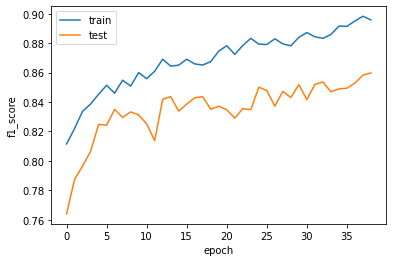

In [32]:
plt.plot(model_history.history['f1_score'])
plt.plot(model_history.history['val_f1_score'])
# plt.title('model f1_score')
plt.ylabel('f1_score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Modelo Base Resnet50 + 3 Dense

Una vez hemos conseguido un modelo que parece funcionar de forma correcta, emepzamos añadir nuevas capas para añadir cierta complejidad al modelo. De esta forma, las capas buscaran patrones mas complejos en cada imagen.

Se añaden las siguientes capas Dense al modelo anterior:

*   Dense(2048, activation='relu')
*   Dense(512, activation='relu')
*   Dense(1024, activation='relu')
*   Dropout(0.25)


Se modificó el orden las capas, pero el mejor modelo seguía el orden anterior.


In [22]:
base_model = tf.keras.applications.ResNet50(input_shape = (224, 224, 3), 
                                            classes     = 25,
                                            include_top  = False)

image_batch, label_batch = next(iter(train_data_gen))
feature_batch = base_model(image_batch)
base_model.trainable = False

dense_layer_2048 = Dense(2048, activation='relu')
dense_layer_512  = Dense(512, activation='relu')
dense_layer_1024 = Dense(1024, activation='relu')

dropout          = Dropout(0.25)

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = keras.layers.Dense(25, activation='softmax')

model_1 = tf.keras.Sequential([
  base_model,
  global_average_layer,
  dense_layer_2048,
  dropout,
  dense_layer_512,
  dropout,
  dense_layer_1024,
  prediction_layer
])

model_1.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 2048)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 2048)              4196352   
_________________________________________________________________
dropout_6 (Dropout)          multiple                  0         
_________________________________________________________________
dense_14 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dense_15 (Dense)             (None, 1024)              525312    
_________________________________________________________________
dense_16 (Dense)             (None, 25)               

In [ ]:
opt = tf.keras.optimizers.Adagrad()

callback = tf.keras.callbacks.EarlyStopping(monitor='f1_score', patience=5)

model_1.compile(loss="categorical_crossentropy",
              optimizer=opt,
	            metrics=[tfa.metrics.F1Score(num_classes=25, average='weighted')],
              )

In [ ]:
tf.random.set_seed(2021)

model_history_1 = model_1.fit(  
    train_data_gen,
    epochs=50,
    validation_data=valid_data_gen,
    validation_steps= valid_data_gen.n // batch_size)

Epoch 1/50
63/63 [==============================] - 383s 6s/step - loss: 3.1334 - f1_score: 0.1046 - val_loss: 2.5181 - val_f1_score: 0.4795
Epoch 2/50
63/63 [==============================] - 378s 6s/step - loss: 2.5349 - f1_score: 0.3676 - val_loss: 1.9645 - val_f1_score: 0.6243
Epoch 3/50
63/63 [==============================] - 390s 6s/step - loss: 2.0416 - f1_score: 0.5068 - val_loss: 1.5346 - val_f1_score: 0.7232
Epoch 4/50
63/63 [==============================] - 389s 6s/step - loss: 1.6152 - f1_score: 0.6252 - val_loss: 1.2329 - val_f1_score: 0.7495
Epoch 5/50
63/63 [==============================] - 388s 6s/step - loss: 1.3752 - f1_score: 0.6677 - val_loss: 1.0576 - val_f1_score: 0.7800
Epoch 6/50
63/63 [==============================] - 390s 6s/step - loss: 1.1837 - f1_score: 0.7032 - val_loss: 0.9077 - val_f1_score: 0.7835
Epoch 7/50
63/63 [==============================] - 386s 6s/step - loss: 1.0406 - f1_score: 0.7454 - val_loss: 0.8434 - val_f1_score: 0.7952
Epoch 8/50
63

Si dibujamos la gráfica asociada a la métrica F1Score obtenida en el conjunto de datos de entrenamiento y valdiación, podemos observar que no existe diferencia entre ambos a medida que aumentan las epocas. 

Esto nos indica que nuestro modelo no sufre de sobreajuste o subajuste.

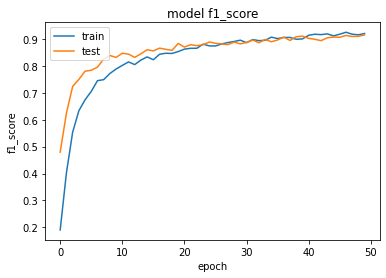

In [ ]:
plt.plot(model_history_1.history['f1_score'])
plt.plot(model_history_1.history['val_f1_score'])
plt.title('model f1_score')
plt.ylabel('f1_score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Modelo Base Resnet50 + 6 Dense

Como hemos mejorado el modelo anterior añadiendo nuevas capas, procedemos a realizar lo mismo.
De esta forma, las nuevas capas añadidas son las siguientes:

* Dense(256, activation='relu')
* Dense(128, activation='relu')
* Dense(52,  activation='relu')



In [15]:
base_model = tf.keras.applications.ResNet50(input_shape = (224, 224, 3), 
                                            classes     = 25,
                                            include_top  = False)

image_batch, label_batch = next(iter(train_data_gen))
feature_batch = base_model(image_batch)
base_model.trainable = False

dense_layer_2048 = Dense(2048, activation='relu')
dense_layer_512  = Dense(512,  activation='relu')
dense_layer_1024 = Dense(1024, activation='relu')

dense_layer_256  = Dense(256, activation='relu')
dense_layer_128  = Dense(128, activation='relu')
dense_layer_52   = Dense(52,  activation='relu')

dropout          = Dropout(0.25)

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = keras.layers.Dense(25, activation='softmax')

model_2 = tf.keras.Sequential([
  base_model,
  dense_layer_2048,
  dropout,
  dense_layer_512,
  dropout,
  dense_layer_1024,
  dropout,
  dense_layer_256,
  dropout,
  dense_layer_128,
  dropout,
  dense_layer_52,
  dropout,
  global_average_layer,
  prediction_layer
])

94773248/94765736 [==============================] - 1s 0us/step


In [16]:
opt = tf.keras.optimizers.Adagrad()

callback = tf.keras.callbacks.EarlyStopping(monitor='f1_score', patience=5)

model_2.compile(loss="categorical_crossentropy",
              optimizer=opt,
	            metrics=[tfa.metrics.F1Score(num_classes=25, average='weighted')],
              )

In [17]:
tf.random.set_seed(2021)

model_history_2 = model_2.fit(  
    train_data_gen,
    epochs=40,
    validation_data=valid_data_gen,
    validation_steps= valid_data_gen.n // batch_size)

Epoch 1/40
63/63 [==============================] - 430s 7s/step - loss: 3.2786 - f1_score: 0.0136 - val_loss: 3.1866 - val_f1_score: 0.0537
Epoch 2/40
63/63 [==============================] - 426s 7s/step - loss: 3.2072 - f1_score: 0.0386 - val_loss: 3.1609 - val_f1_score: 0.0871
Epoch 3/40
63/63 [==============================] - 426s 7s/step - loss: 3.1815 - f1_score: 0.0483 - val_loss: 3.1278 - val_f1_score: 0.0937
Epoch 4/40
63/63 [==============================] - 427s 7s/step - loss: 3.1466 - f1_score: 0.0673 - val_loss: 3.0794 - val_f1_score: 0.0860
Epoch 5/40
63/63 [==============================] - 425s 7s/step - loss: 3.1216 - f1_score: 0.0738 - val_loss: 3.0130 - val_f1_score: 0.0864
Epoch 6/40
63/63 [==============================] - 424s 7s/step - loss: 3.0579 - f1_score: 0.0983 - val_loss: 2.9170 - val_f1_score: 0.1266
Epoch 7/40
63/63 [==============================] - 428s 7s/step - loss: 2.9784 - f1_score: 0.1106 - val_loss: 2.7745 - val_f1_score: 0.1981
Epoch 8/40
63

Dibujamos una gráfica que enfrente los valores de *f1_score* y *val_f1_score*

In [18]:
from matplotlib import pyplot as plt

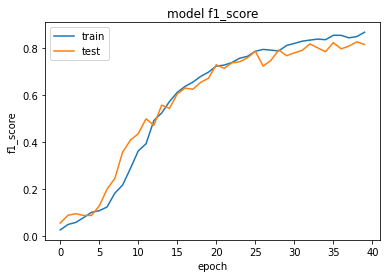

In [19]:
plt.plot(model_history_2.history['f1_score'])
plt.plot(model_history_2.history['val_f1_score'])
plt.title('model f1_score')
plt.ylabel('f1_score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Modelo Base Resnet50 + 3 Dense + 2 Conv2D

Como hemos visto. el modelo anterior no muestra diferencias notables respecto al modelo con 3 capas, por lo que se decide mantener el menor número de capas (3) para evitar crear modelos muy complejos y pesados.

Una vez hemos "encontrado" el número de capas Dense óptimas, se decide aumentar la complejidad del modelo haciendo uso de las capas Conv2D.

In [ ]:
base_model = tf.keras.applications.ResNet50(input_shape = (224, 224, 3), 
                                            classes     = 25,
                                            include_top  = False)

image_batch, label_batch = next(iter(train_data_gen))
feature_batch = base_model(image_batch)
base_model.trainable = False

dense_layer_2048 = Dense(2048, activation='relu')
dense_layer_512  = Dense(512,  activation='relu')
dense_layer_1024 = Dense(1024, activation='relu')

conv_1024 = Conv2D(1024, (3,3), activation='relu')
conv_512  = Conv2D(512, (3,3), activation='relu')

flattern  = Flatten()
batch_normal = BatchNormalization()
dropout   = Dropout(0.25)

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = keras.layers.Dense(25, activation='softmax')

model_2 = tf.keras.Sequential([
  base_model,
  conv_1024,
  conv_512,
  flattern,
  dense_layer_2048,
  dropout,
  dense_layer_512,
  dropout,
  dense_layer_1024,
  prediction_layer
])

In [ ]:
opt = tf.keras.optimizers.Adagrad()

callback = tf.keras.callbacks.EarlyStopping(monitor='f1_score', patience=5)

model_2.compile(loss="categorical_crossentropy",
              optimizer=opt,
	            metrics=[ 'accuracy', tfa.metrics.F1Score(num_classes=25, average='weighted')],
              )

In [ ]:
tf.random.set_seed(2021)

model_history_2 = model_2.fit(  
    train_data_gen,
    epochs=50,
    validation_data=valid_data_gen,
    validation_steps= valid_data_gen.n // batch_size)

Epoch 1/50
63/63 [==============================] - 534s 8s/step - loss: 2.9284 - accuracy: 0.1840 - f1_score: 0.1570 - val_loss: 1.7577 - val_accuracy: 0.5104 - val_f1_score: 0.4624
Epoch 2/50
63/63 [==============================] - 522s 8s/step - loss: 1.6498 - accuracy: 0.5271 - f1_score: 0.5170 - val_loss: 1.0158 - val_accuracy: 0.6979 - val_f1_score: 0.6819
Epoch 3/50
63/63 [==============================] - 520s 8s/step - loss: 1.0721 - accuracy: 0.6886 - f1_score: 0.6852 - val_loss: 0.7204 - val_accuracy: 0.7896 - val_f1_score: 0.7903
Epoch 4/50
63/63 [==============================] - 518s 8s/step - loss: 0.7728 - accuracy: 0.7669 - f1_score: 0.7673 - val_loss: 0.6525 - val_accuracy: 0.8021 - val_f1_score: 0.8001
Epoch 5/50
63/63 [==============================] - 517s 8s/step - loss: 0.6814 - accuracy: 0.7969 - f1_score: 0.7958 - val_loss: 0.5773 - val_accuracy: 0.8146 - val_f1_score: 0.8170
Epoch 6/50
63/63 [==============================] - 517s 8s/step - loss: 0.5503 - acc

En este caso, al dibujar el gráfico que enfrenta ambos scores (entrenamiento y validacion) parece que nuestro modelo se está ajustando demasiado al conjunto de entrenamiento. Aun así, este modelo obtiene los mejores datos de validación, por lo que será la base para aplicar *Fine Tunning* 


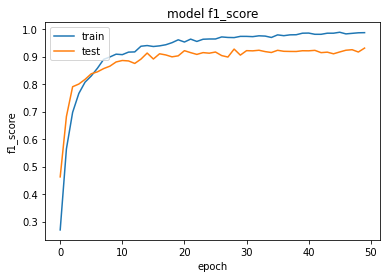

In [ ]:
plt.plot(model_history_2.history['f1_score'])
plt.plot(model_history_2.history['val_f1_score'])
plt.title('model f1_score')
plt.ylabel('f1_score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()